In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
#https://data.mendeley.com/datasets/c3xvj5snvv/1

## Zero-shot Classification
### Load Data and Data Processing

Before loading, manually remove empty tweets and tweets with labels other than [1, 2, 3].

In [ ]:
# Load the test dataset
# It loads the csv file located at that path into a pandas DataFrame(df).
# The read_csv function from pandas reads the data from the CSV file and stores it in a structured format(rows and columns)
# After this, df is a pandas DataFrame containing the data from the csv file.
# df = pd.read_excel("data_cleaned.xlsx")
df= pd.read_csv('/content/drive/My Drive/UrbanComputingFall24/1_TestSet_3Class_WithColumnName.csv', encoding='latin1')
df

,label,id,text
0,1,s884397880253059074,"As highway construction heats up, please slow ..."
1,1,s902255612217708545,Crash SB Telegraph near Joy Road in Redford To...
2,1,s896765983695794179,Incident on #FLine BothDir/BothDir at Neptune ...
3,1,s900820637140340737,Updated: Crash in Palm Beach on highway north ...
4,0,s840215804671057921,Shared spaces and new amenities are redefining...
...,...,...,...
10136,0,s862745416491814913,How cities may benefit from dog parks: Research
10137,0,s903734990919262208,Project to deepen Corpus Christi Ship Channel ...
10138,1,s829933926722392067,NB/SB at Ontario Ave will be closed from : pm ...
10139,1,s904621967155896320,Incident on #NJ495 WB at highway&amp;


In [ ]:
# Verify label in the dataset
print("Loaded cleaned data:")
print(df.head())

# Check unique values in the 'label' column
print("Unique values in 'label' column after cleaning:", df['label'].unique())

Loaded cleaned data:
   label                   id  \
0      1  s884397880253059074   
1      1  s902255612217708545   
2      1  s896765983695794179   
3      1  s900820637140340737   
4      0  s840215804671057921   

                                                text  
0  As highway construction heats up, please slow ...  
1  Crash SB Telegraph near Joy Road in Redford To...  
2  Incident on #FLine BothDir/BothDir at Neptune ...  
3  Updated: Crash in Palm Beach on highway north ...  
4  Shared spaces and new amenities are redefining...  
Unique values in 'label' column after cleaning: [1 0 2]


#### Data preprocessing:
Clean the text column to remove unnecessary noise(eg. URLs, hashtags, special characters) that might confuse the model.
```
df['text'] = df['text'].str.replace(r"http\S+", "", regex=True)  # Remove URLs
df['text'] = df['text'].str.replace(r"[^\w\s]", "", regex=True)  # Remove special characters
```

In [ ]:
import re

# Function to clean text
def clean_text(text):
    # Remove hashtags
    text = re.sub(r"#\S+", "", text)
    # Remove URLs
    text = re.sub(r"http\S+|www.\S+", "", text)
    # Remove non-English characters, keeping only letters, numbers, and spaces
    text = re.sub(r"[^\x00-\x7F]+", "", text)  # Remove non-ASCII characters (like Chinese)
    # Remove special characters, keep only letters, numbers, and spaces
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply the cleaning to the text column
print("Cleaning the text column...")
df['text'] = df['text'].apply(clean_text)

# Verify the cleaned text
print("Sample cleaned text:")
print(df['text'].head())

# Check if any special characters are present
special_chars = df['text'].apply(lambda x: bool(re.search(r"[^a-zA-Z0-9\s]", x)))
print(f"Rows with special characters: {special_chars.sum()}")  # Should be 0

# Check for non-ASCII characters
non_ascii = df['text'].apply(lambda x: bool(re.search(r"[^\x00-\x7F]", x)))
print(f"Rows with non-English characters: {non_ascii.sum()}")  # Should be 0

# Check for empty or very short rows (less than 5 characters, which typically less than 2 words)
short_rows = df['text'].apply(lambda x: len(x.strip()) < 5)
print(f"Rows with very short text: {short_rows.sum()}")  # Should be minimal or 0


Cleaning the text column...
Sample cleaned text:
0    As highway construction heats up please slow d...
1    Crash SB Telegraph near Joy Road in Redford To...
2    Incident on BothDirBothDir at Neptune Avenue S...
3    Updated Crash in Palm Beach on highway north a...
4    Shared spaces and new amenities are redefining...
Name: text, dtype: object
Rows with special characters: 0
Rows with non-English characters: 0
Rows with very short text: 2


In [ ]:
# Remove rows where 'text' is too short
df = df[df['text'].apply(lambda x: len(x.strip()) >= 5)].reset_index(drop=True)

# Verify that the rows have been removed
print("Rows with very short text have been removed.")
print(f"Rows with very short text after cleaning: {df['text'].apply(lambda x: len(x.strip()) < 5).sum()}")  # Should be 0
df

Rows with very short text have been removed.
Rows with very short text after cleaning: 0


,label,id,text
0,1,s884397880253059074,As highway construction heats up please slow d...
1,1,s902255612217708545,Crash SB Telegraph near Joy Road in Redford To...
2,1,s896765983695794179,Incident on BothDirBothDir at Neptune Avenue S...
3,1,s900820637140340737,Updated Crash in Palm Beach on highway north a...
4,0,s840215804671057921,Shared spaces and new amenities are redefining...
...,...,...,...
10134,0,s862745416491814913,How cities may benefit from dog parks Research
10135,0,s903734990919262208,Project to deepen Corpus Christi Ship Channel ...
10136,1,s829933926722392067,NBSB at Ontario Ave will be closed from pm unt...
10137,1,s904621967155896320,Incident on WB at highwayamp


## Label Mapping
label mapping techniques were utilized to align traffic categories with the output labels or prompts recognized by the zero-shot learning models

In [ ]:
# Define the conditions
conditions = [
    df['label'] == 0,  # Condition for class 0
    df['label'] == 1,  # Condition for class 1
    df['label'] == 2   # Condition for class 2
]

# Define the corresponding choices
choices = [
    'Non-Traffic Related',   # Label for class 0
    'Traffic Incident',      # Label for class 1
    'Traffic Condition'      # Label for class 2
]

# Create the new column using np.select
df['Textlabel'] = np.select(conditions, choices, default='Unknown')

# Display the DataFrame
df

,label,id,text,Textlabel
0,1,s884397880253059074,As highway construction heats up please slow d...,Traffic Incident
1,1,s902255612217708545,Crash SB Telegraph near Joy Road in Redford To...,Traffic Incident
2,1,s896765983695794179,Incident on BothDirBothDir at Neptune Avenue S...,Traffic Incident
3,1,s900820637140340737,Updated Crash in Palm Beach on highway north a...,Traffic Incident
4,0,s840215804671057921,Shared spaces and new amenities are redefining...,Non-Traffic Related
...,...,...,...,...
10134,0,s862745416491814913,How cities may benefit from dog parks Research,Non-Traffic Related
10135,0,s903734990919262208,Project to deepen Corpus Christi Ship Channel ...,Non-Traffic Related
10136,1,s829933926722392067,NBSB at Ontario Ave will be closed from pm unt...,Traffic Incident
10137,1,s904621967155896320,Incident on WB at highwayamp,Traffic Incident


In [ ]:
#1.model_name = "bert-base-uncased"
#2.model_name = "bert-large-uncased"

#3.model_name = "roberta-large"

#4.model_name = "facebook/bart-large"
#5.model_name="facebook/bart-large-mnli"
#6.model_name ="valhalla/distilbart-mnli-12-1"
#7.model_name="cross-encoder/nli-distilroberta-base"
#8.model_name = "gpt2"
# from transformers import pipeline
# from datasets import Dataset
# from sklearn.metrics import classification_report
# from sklearn.metrics import ConfusionMatrixDisplay
import torch

import time
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from transformers import pipeline
from datasets import Dataset

### Model 1. BERT (bert-base-uncased)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


Map:   0%|          | 0/10139 [00:00<?, ? examples/s]

Accuracy: 49.13%
                     precision    recall  f1-score   support

Non-Traffic Related       0.61      0.52      0.56      5069
   Traffic Incident       0.00      0.00      0.00      1608
  Traffic Condition       0.50      0.68      0.57      3462

           accuracy                           0.49     10139
          macro avg       0.37      0.40      0.38     10139
       weighted avg       0.47      0.49      0.48     10139



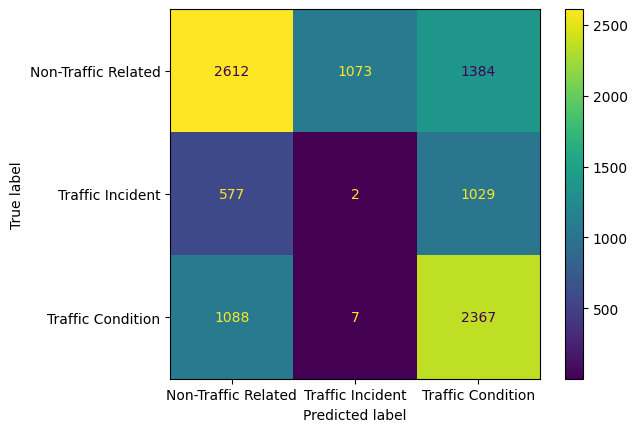

Total Running Time: 350.08 seconds


In [ ]:
# Start the timer
start_time = time.time()
# Use the "bert-base-uncased" model for zero-shot classification
model_name = "bert-base-uncased"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Define the three labels and hypothesis template
labels = ['Non-Traffic Related', 'Traffic Incident', 'Traffic Condition']
hypothesis_template = "This text is {}."

# Apply the classifier directly to the DataFrame using Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

def apply_classifier(batch):
    results = classifier(batch['text'], labels, hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)
df = df_dataset.to_pandas()  # Convert back to pandas DataFrame

# Calculate metrics
y_true = df['Textlabel'].str.lower()
y_pred = df['Predicted_label'].str.lower()

# Accuracy
accuracy = (y_pred == y_true).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification Report
report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
print(report)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
plt.show()

# End the timer and print running time
end_time = time.time()
print(f"Total Running Time: {end_time - start_time:.2f} seconds")

In [ ]:
#1.model_name = "bert-base-uncased"
# Set up the device
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU

# Use the "bert-base-uncased" model for zero-shot classification
model_name = "bert-base-uncased"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Convert the cleaned pandas DataFrame to a Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

# Define the three labels
labels = [
    'Non-Traffic Related',        # Class 0
    'Traffic Incident',           # Class 1
    'Traffic Condition'           # Class 2
]

# Define the hypothesis template
hypothesis_template = "This text is {}."

# Function to apply the classifier to each batch
def apply_classifier(batch):
    results = classifier(batch['text'], labels, hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

# Apply the function using map in batches
df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)

# Convert the dataset back to a pandas DataFrame
df = df_dataset.to_pandas()

# Calculate the accuracy
correct_predictions = sum(df['Predicted_label'].str.lower() == df['Textlabel'].str.lower())
accuracy = correct_predictions / len(df)
print(f"Accuracy: {accuracy * 100:.2f}%")

# True and predicted labels
y_true = df['Textlabel'].str.lower()
y_pred = df['Predicted_label'].str.lower()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
print(report)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
plt.show()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


Map:   0%|          | 0/10139 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


KeyboardInterrupt: 

### Methods to improve classification accuracy in zero-shot learning
#### Trail 1: Label wording
Label wording matters in zero-shot classification. Zero-shot classification relies heavily on natural language understanding to evaluate how well the text aligns with the labels. In essence, the model is not directly "learning" from the data; instead, it uses the labels as descriptive prompts to predict the most likely category.

The previous label was 'Non-Traffic Related', which is precise but abstract. A more descriptive labels include:
```
labels = [
    'This text is not related to traffic or accidents.',   # Class 0
    'This text is about specific traffic incidents, such as accidents, crashes, or road closures.',  # Class 1
    'This text describes general traffic conditions, such as congestion, delays, or construction-related traffic.'  # Class 2
]
```
Results for Trail 1: Failed. Descriptive labels make no significant improvement for the zero-shot learning task. For some models, the accuracy even gets lower. A possible reason can be that descriptive labels are longer and more complex, which might confuse the model because it has to evaluate more intricate hypotheses.

In [ ]:
#1.model_name = "bert-base-uncased"
# Set up the device
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU
# Define the conditions
conditions = [
    df['label'] == 0,  # Condition for class 0
    df['label'] == 1,  # Condition for class 1
    df['label'] == 2   # Condition for class 2
]

# Define the corresponding choices
choices = [
    'This text is not related to traffic or accidents.',   # Class 0
    'This text is about specific traffic incidents, such as accidents, crashes, or road closures.',  # Class 1
    'This text describes general traffic conditions, such as congestion, delays, or construction-related traffic.'  # Class 2
]

# Create the new column using np.select
df['Textlabel'] = np.select(conditions, choices, default='Unknown')

# Use the "bert-base-uncased" model for zero-shot classification
model_name = "bert-base-uncased"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Convert the cleaned pandas DataFrame to a Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

# Define the three labels
labels = [
    'This text is not related to traffic or accidents.',   # Class 0
    'This text is about specific traffic incidents, such as accidents, crashes, or road closures.',  # Class 1
    'This text describes general traffic conditions, such as congestion, delays, or construction-related traffic.'  # Class 2
]

# Define the hypothesis template
hypothesis_template = "This text is {}."

# Function to apply the classifier to each batch
def apply_classifier(batch):
    results = classifier(batch['text'], labels, hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

# Apply the function using map in batches
df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)

# Convert the dataset back to a pandas DataFrame
df = df_dataset.to_pandas()

# Calculate the accuracy
correct_predictions = sum(df['Predicted_label'].str.lower() == df['Textlabel'].str.lower())
accuracy = correct_predictions / len(df)
print(f"Accuracy: {accuracy * 100:.2f}%")
# Using detailed label, the accuracy decreases.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


Map:   0%|          | 0/10139 [00:00<?, ? examples/s]

Accuracy: 37.40%


In [ ]:
#6.model_name ="valhalla/distilbart-mnli-12-1"
# Set up the device
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU
# Define the conditions
conditions = [
    df['label'] == 0,  # Condition for class 0
    df['label'] == 1,  # Condition for class 1
    df['label'] == 2   # Condition for class 2
]

# Define the corresponding choices
choices = [
    'This text is not related to traffic or accidents.',   # Class 0
    'This text is about specific traffic incidents, such as accidents, crashes, or road closures.',  # Class 1
    'This text describes general traffic conditions, such as congestion, delays, or construction-related traffic.'  # Class 2
]

# Create the new column using np.select
df['Textlabel'] = np.select(conditions, choices, default='Unknown')

# Use the "valhalla/distilbart-mnli-12-1" model for zero-shot classification
model_name = "valhalla/distilbart-mnli-12-1"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Convert the cleaned pandas DataFrame to a Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

# Define the three labels
labels = [
    'This text is not related to traffic or accidents.',   # Class 0
    'This text is about specific traffic incidents, such as accidents, crashes, or road closures.',  # Class 1
    'This text describes general traffic conditions, such as congestion, delays, or construction-related traffic.'  # Class 2
]

# Define the hypothesis template
hypothesis_template = "This text is {}."

# Function to apply the classifier to each batch
def apply_classifier(batch):
    results = classifier(batch['text'], labels, hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

# Apply the function using map in batches
df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)

# Convert the dataset back to a pandas DataFrame
df = df_dataset.to_pandas()

# Calculate the accuracy
correct_predictions = sum(df['Predicted_label'].str.lower() == df['Textlabel'].str.lower())
accuracy = correct_predictions / len(df)
print(f"Accuracy: {accuracy * 100:.2f}%")
# Run time: 6min

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/890M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Map:   0%|          | 0/10139 [00:00<?, ? examples/s]

Accuracy: 28.03%


#### Trail 2: Preprocessing text
Clearn the text column to remove unnecessary noise(eg. URLs, hashtags, special characters) that might confuse the model.
```
df['text'] = df['text'].str.replace(r"http\S+", "", regex=True)  # Remove URLs
df['text'] = df['text'].str.replace(r"[^\w\s]", "", regex=True)  # Remove special characters
```


In [ ]:
import re

# Function to clean text
def clean_text(text):
    # Remove hashtags
    text = re.sub(r"#\S+", "", text)
    # Remove URLs
    text = re.sub(r"http\S+|www.\S+", "", text)
    # Remove non-English characters, keeping only letters, numbers, and spaces
    text = re.sub(r"[^\x00-\x7F]+", "", text)  # Remove non-ASCII characters (like Chinese)
    # Remove special characters, keep only letters, numbers, and spaces
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply the cleaning to the text column
print("Cleaning the text column...")
df['text'] = df['text'].apply(clean_text)

# Verify the cleaned text
print("Sample cleaned text:")
print(df['text'].head())

# Check if any special characters are present
special_chars = df['text'].apply(lambda x: bool(re.search(r"[^a-zA-Z0-9\s]", x)))
print(f"Rows with special characters: {special_chars.sum()}")  # Should be 0

# Check for non-ASCII characters
non_ascii = df['text'].apply(lambda x: bool(re.search(r"[^\x00-\x7F]", x)))
print(f"Rows with non-English characters: {non_ascii.sum()}")  # Should be 0

# Check for empty or very short rows
short_rows = df['text'].apply(lambda x: len(x.strip()) < 5)
print(f"Rows with very short text: {short_rows.sum()}")  # Should be minimal or 0


Cleaning the text column...
Sample cleaned text:
0    As highway construction heats up please slow d...
1    Crash SB Telegraph near Joy Road in Redford To...
2    Incident on BothDirBothDir at Neptune Avenue S...
3    Updated Crash in Palm Beach on highway north a...
4    Shared spaces and new amenities are redefining...
Name: text, dtype: object
Rows with special characters: 0
Rows with non-English characters: 0
Rows with very short text: 2


In [ ]:
# View rows with very short text
short_text_rows = df[df['text'].apply(lambda x: len(x.strip()) < 5)]
print("Rows with very short text:")
print(short_text_rows)


Rows with very short text:
      label                   id text            Textlabel  \
4835      1  s901118289425952768          Traffic Incident   
5373      0  s900398359021858816       Non-Traffic Related   

          Predicted_label  
4835  Non-Traffic Related  
5373  Non-Traffic Related  


In [ ]:
# Remove rows where 'text' is too short
df = df[df['text'].apply(lambda x: len(x.strip()) >= 5)].reset_index(drop=True)

# Verify that the rows have been removed
print("Rows with very short text have been removed.")
print(f"Rows with very short text after cleaning: {df['text'].apply(lambda x: len(x.strip()) < 5).sum()}")  # Should be 0
df

Rows with very short text have been removed.
Rows with very short text after cleaning: 0


,label,id,text,Textlabel,Predicted_label
0,1,s884397880253059074,As highway construction heats up please slow d...,Traffic Incident,Traffic Condition
1,1,s902255612217708545,Crash SB Telegraph near Joy Road in Redford To...,Traffic Incident,Non-Traffic Related
2,1,s896765983695794179,Incident on BothDirBothDir at Neptune Avenue S...,Traffic Incident,Traffic Condition
3,1,s900820637140340737,Updated Crash in Palm Beach on highway north a...,Traffic Incident,Traffic Incident
4,0,s840215804671057921,Shared spaces and new amenities are redefining...,Non-Traffic Related,Traffic Condition
...,...,...,...,...,...
10132,0,s862745416491814913,How cities may benefit from dog parks Research,Non-Traffic Related,Traffic Condition
10133,0,s903734990919262208,Project to deepen Corpus Christi Ship Channel ...,Non-Traffic Related,Non-Traffic Related
10134,1,s829933926722392067,NBSB at Ontario Ave will be closed from pm unt...,Traffic Incident,Non-Traffic Related
10135,1,s904621967155896320,Incident on WB at highwayamp,Traffic Incident,Non-Traffic Related


After data clearning, we re-run the model 1a

In [ ]:
#1.model_name = "bert-base-uncased"
# Set up the device
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU
# Define the conditions
conditions = [
    df['label'] == 0,  # Condition for class 0
    df['label'] == 1,  # Condition for class 1
    df['label'] == 2   # Condition for class 2
]

# Define the corresponding choices
choices = [
    'This text is not related to traffic or accidents.',   # Class 0
    'This text is about specific traffic incidents, such as accidents, crashes, or road closures.',  # Class 1
    'This text describes general traffic conditions, such as congestion, delays, or construction-related traffic.'  # Class 2
]

# Create the new column using np.select
df['Textlabel'] = np.select(conditions, choices, default='Unknown')

# Use the "bert-base-uncased" model for zero-shot classification
model_name = "bert-base-uncased"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Convert the cleaned pandas DataFrame to a Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

# Define the three labels
labels = [
    'This text is not related to traffic or accidents.',   # Class 0
    'This text is about specific traffic incidents, such as accidents, crashes, or road closures.',  # Class 1
    'This text describes general traffic conditions, such as congestion, delays, or construction-related traffic.'  # Class 2
]

# Define the hypothesis template
hypothesis_template = "This text is {}."

# Function to apply the classifier to each batch
def apply_classifier(batch):
    results = classifier(batch['text'], labels, hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

# Apply the function using map in batches
df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)

# Convert the dataset back to a pandas DataFrame
df = df_dataset.to_pandas()

# Calculate the accuracy
correct_predictions = sum(df['Predicted_label'].str.lower() == df['Textlabel'].str.lower())
accuracy = correct_predictions / len(df)
print(f"Accuracy: {accuracy * 100:.2f}%")
# Using detailed label, the accuracy decreases.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


Map:   0%|          | 0/10137 [00:00<?, ? examples/s]

Accuracy: 19.94%


#### Trail 3: Model choice
Consider using models explicitly trained for zero-shot tasks, such as facebook/bart-large-mnli, or eoberta-large-mnli.
This works! The best accuracy we got here is 81.76%

4. Batch size
Adjust the batch size to optimize performance.
5. Weight adjustments
If the dataset is imbalanced, consider assigning weights to labels during post-processing.

In [ ]:
#6.model_name ="valhalla/distilbart-mnli-12-1"
# Set up the device
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU
# Define the conditions
conditions = [
    df['label'] == 0,  # Condition for class 0
    df['label'] == 1,  # Condition for class 1
    df['label'] == 2   # Condition for class 2
]
# Define the corresponding choices
choices = [
    'Non-Traffic Related',   # Label for class 0
    'Traffic Incident',      # Label for class 1
    'Traffic Condition'      # Label for class 2
]

# Create the new column using np.select
df['Textlabel'] = np.select(conditions, choices, default='Unknown')

# Use the "valhalla/distilbart-mnli-12-1" model for zero-shot classification
model_name = "valhalla/distilbart-mnli-12-1"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Convert the cleaned pandas DataFrame to a Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

# Define the three labels
labels = [
    'Non-Traffic Related',   # Label for class 0
    'Traffic Incident',      # Label for class 1
    'Traffic Condition'      # Label for class 2
]

# Define the hypothesis template
hypothesis_template = "This text is {}."

# Function to apply the classifier to each batch
def apply_classifier(batch):
    results = classifier(batch['text'], labels, hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

# Apply the function using map in batches
df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)

# Convert the dataset back to a pandas DataFrame
df = df_dataset.to_pandas()

# Calculate the accuracy
correct_predictions = sum(df['Predicted_label'].str.lower() == df['Textlabel'].str.lower())
accuracy = correct_predictions / len(df)
print(f"Accuracy: {accuracy * 100:.2f}%")
# Run time: 6min

Map:   0%|          | 0/10139 [00:00<?, ? examples/s]

Accuracy: 81.76%


### Model 2. BERT(bert-large-uncased)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


Map:   0%|          | 0/10139 [00:00<?, ? examples/s]

Accuracy: 35.88%
                     precision    recall  f1-score   support

Non-Traffic Related       0.96      0.30      0.45      5069
   Traffic Incident       0.22      0.79      0.34      1608
  Traffic Condition       0.30      0.25      0.27      3462

           accuracy                           0.36     10139
          macro avg       0.50      0.44      0.36     10139
       weighted avg       0.62      0.36      0.38     10139



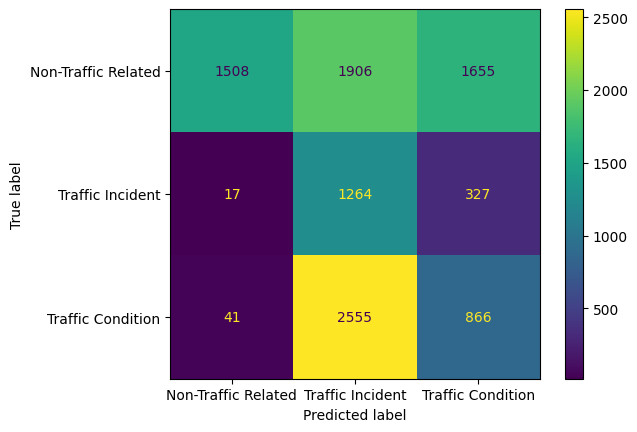

Total Running Time: 518.63 seconds


In [ ]:
# Start the timer
start_time = time.time()
# Set up the device
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU
# Use the "bert-large-uncased" model for zero-shot classification
model_name = "bert-large-uncased"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Define the three labels and hypothesis template
labels = ['Non-Traffic Related', 'Traffic Incident', 'Traffic Condition']
hypothesis_template = "This text is {}."

# Apply the classifier directly to the DataFrame using Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

def apply_classifier(batch):
    results = classifier(batch['text'], labels, hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)
df = df_dataset.to_pandas()  # Convert back to pandas DataFrame

# Calculate metrics
y_true = df['Textlabel'].str.lower()
y_pred = df['Predicted_label'].str.lower()

# Accuracy
accuracy = (y_pred == y_true).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification Report
report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
print(report)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
plt.show()

# End the timer and print running time
end_time = time.time()
print(f"Total Running Time: {end_time - start_time:.2f} seconds")

In [ ]:
#2. "bert-large-uncased"
# Set up the device
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU
# Define the conditions
conditions = [
    df['label'] == 0,  # Condition for class 0
    df['label'] == 1,  # Condition for class 1
    df['label'] == 2   # Condition for class 2
]
# Define the corresponding choices
choices = [
    'Non-Traffic Related',   # Label for class 0
    'Traffic Incident',      # Label for class 1
    'Traffic Condition'      # Label for class 2
]

# Create the new column using np.select
df['Textlabel'] = np.select(conditions, choices, default='Unknown')

# Use the "bert-large-uncased" model for zero-shot classification
model_name = "bert-large-uncased"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Convert the cleaned pandas DataFrame to a Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

# Define the three labels
labels = [
    'Non-Traffic Related',   # Label for class 0
    'Traffic Incident',      # Label for class 1
    'Traffic Condition'      # Label for class 2
]

# Define the hypothesis template
hypothesis_template = "This text is {}."

# Function to apply the classifier to each batch
def apply_classifier(batch):
    results = classifier(batch['text'], labels, hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

# Apply the function using map in batches
df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)

# Convert the dataset back to a pandas DataFrame
df = df_dataset.to_pandas()

# Calculate the accuracy
correct_predictions = sum(df['Predicted_label'].str.lower() == df['Textlabel'].str.lower())
accuracy = correct_predictions / len(df)
print(f"Accuracy: {accuracy * 100:.2f}%")
# Run time: 6min

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


Map:   0%|          | 0/10139 [00:00<?, ? examples/s]

Accuracy: 21.88%


### Model 3. Roberta-large

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


Map:   0%|          | 0/10139 [00:00<?, ? examples/s]

Accuracy: 40.22%
                     precision    recall  f1-score   support

Non-Traffic Related       0.65      0.60      0.62      5069
   Traffic Incident       0.19      0.62      0.29      1608
  Traffic Condition       0.48      0.02      0.03      3462

           accuracy                           0.40     10139
          macro avg       0.44      0.41      0.31     10139
       weighted avg       0.52      0.40      0.37     10139



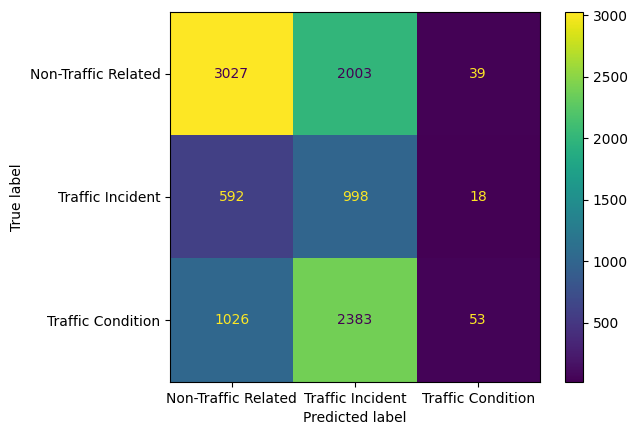

Total Running Time: 580.64 seconds


In [ ]:
# Start the timer
start_time = time.time()
# Set up the device
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU
# Use the "roberta-large" model for zero-shot classification
model_name = "roberta-large"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Define the three labels and hypothesis template
labels = ['Non-Traffic Related', 'Traffic Incident', 'Traffic Condition']
hypothesis_template = "This text is {}."

# Apply the classifier directly to the DataFrame using Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

def apply_classifier(batch):
    results = classifier(batch['text'], labels, hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)
df = df_dataset.to_pandas()  # Convert back to pandas DataFrame

# Calculate metrics
y_true = df['Textlabel'].str.lower()
y_pred = df['Predicted_label'].str.lower()

# Accuracy
accuracy = (y_pred == y_true).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification Report
report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
print(report)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
plt.show()

# End the timer and print running time
end_time = time.time()
print(f"Total Running Time: {end_time - start_time:.2f} seconds")

In [ ]:
# # Set random seeds for reproducibility
# random.seed(42)
# np.random.seed(42)
# torch.manual_seed(42)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(42)

#3. model_name = "roberta-large"
device = 0 if torch.cuda.is_available() else -1  # if GPU is available, use it, otherwise use CPU
# Set up the zero-shot classification pipeline with the BERT model and GPU
model_name = "roberta-large"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Convert the DataFrame to a Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

# Define the lables
# Define the candidate labels
labels = ["Non-Traffic Related", "Traffic Incident", "Traffic Condition"]

# Define the hypothesis template
hypothesis_template = "This text is {}."
#hypothesis_template=hypothesis_template
# Function to apply the classifier to each batch
def apply_classifier(batch):
    # Check for valid text entries
    valid_indices = [i for i, text in enumerate(batch['text']) if text and isinstance(text, str)]  # Ensure text is valid
    valid_texts = [batch['text'][i] for i in valid_indices]

    if valid_texts:  # If there are valid texts, classify them
        results = classifier(valid_texts, labels, hypothesis_template=hypothesis_template)
        predicted_labels = [result["labels"][0] for result in results]
    else:
        predicted_labels = []  # Empty if no valid texts

    # Fill predictions for the entire batch
    all_predicted_labels = [None] * len(batch['text'])
    for i, label in zip(valid_indices, predicted_labels):
        all_predicted_labels[i] = label

    return {'Predicted_label': all_predicted_labels}

# Apply the function using map in batches
df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)

# Convert the Hugging Face Dataset back to a pandas DataFrame
df = df_dataset.to_pandas()

# Map numeric ground truth labels to the corresponding class names
label_mapping = {0: "Non-Traffic Related", 1: "Traffic Incident", 2: "Traffic Condition"}
df['True_Label'] = df['label'].map(label_mapping)

# Calculate accuracy
correct_predictions = sum(df['Predicted_label'].str.lower() == df['True_Label'].str.lower())
accuracy = correct_predictions / len(df)
print(f"Accuracy: {accuracy * 100:.2f}%")

# # Function to apply the classifier to each batch
# def apply_classifier(batch):
#     results = classifier(batch['Text'], labels,hypothesis_template=hypothesis_template)
#     return {'Predicted_label': [result["labels"][0] for result in results]}
# # def apply_classifier(batch):
# #     threshold = 0.7  # Adjust the threshold as needed
# #     results = classifier(batch['Text'], labels, hypothesis_template=hypothesis_template)
# #     predicted_labels = []
# #     for result in results:
# #         # If confidence score of the top prediction is above the threshold, use it, otherwise mark as uncertain
# #         if result["scores"][0] >= threshold:
# #             predicted_labels.append(result["labels"][0])
# #         else:
# #             predicted_labels.append("Uncertain")  # You can handle this case differently
# #     return {'Predicted_label': predicted_labels}

# # Apply the function using map in batches
# df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)

# # Convert the dataset back to a pandas DataFrame
# df = df_dataset.to_pandas()

# # Now compare the predicted genres with the actual genres to calculate the accuracy
# correct_predictions = sum(df['Predicted_label'].str.lower() == df['label'].str.lower())
# accuracy = correct_predictions / len(df)
# print(f"Accuracy: {accuracy * 100:.2f}%")
# #57.39% 42.2

### Model 4. Bart-large

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


Map:   0%|          | 0/10139 [00:00<?, ? examples/s]

Accuracy: 41.67%
                     precision    recall  f1-score   support

Non-Traffic Related       0.98      0.30      0.46      5069
   Traffic Incident       0.13      0.24      0.17      1608
  Traffic Condition       0.42      0.67      0.52      3462

           accuracy                           0.42     10139
          macro avg       0.51      0.40      0.38     10139
       weighted avg       0.65      0.42      0.43     10139



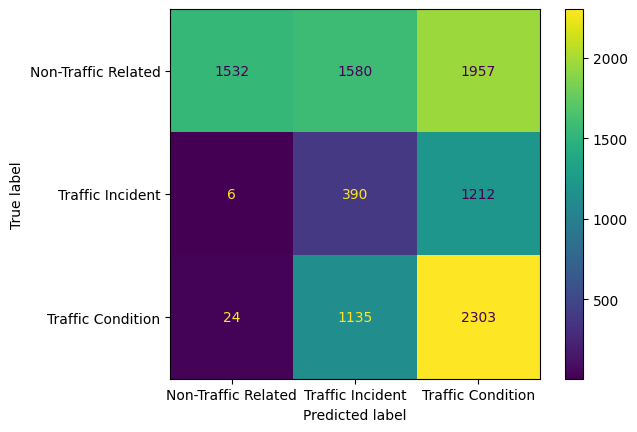

Total Running Time: 741.19 seconds


In [ ]:
# Start the timer
start_time = time.time()
# Set up the device
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU
# Use the "facebook/bart-large" model for zero-shot classification
model_name = "facebook/bart-large"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Define the three labels and hypothesis template
labels = ['Non-Traffic Related', 'Traffic Incident', 'Traffic Condition']
hypothesis_template = "This text is {}."

# Apply the classifier directly to the DataFrame using Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

def apply_classifier(batch):
    results = classifier(batch['text'], labels, hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)
df = df_dataset.to_pandas()  # Convert back to pandas DataFrame

# Calculate metrics
y_true = df['Textlabel'].str.lower()
y_pred = df['Predicted_label'].str.lower()

# Accuracy
accuracy = (y_pred == y_true).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification Report
report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
print(report)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
plt.show()

# End the timer and print running time
end_time = time.time()
print(f"Total Running Time: {end_time - start_time:.2f} seconds")

In [ ]:
#4.model_name = "facebook/bart-large"
device = 0 if torch.cuda.is_available() else -1  # if GPU is available, use it, otherwise use CPU
# Set up the zero-shot classification pipeline with the BERT model and GPU
model_name = "facebook/bart-large"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Convert the DataFrame to a Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

# Define the lables
labels = ['Traffic Incident or Accident Related', 'Not Traffic Incident nor Accident Related']

hypothesis_template = "This text is {}."
#hypothesis_template=hypothesis_template
# Function to apply the classifier to each batch
def apply_classifier(batch):
    results = classifier(batch['Text'], labels,hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

# Apply the function using map in batches
df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)

# Convert the dataset back to a pandas DataFrame
df = df_dataset.to_pandas()

# Now compare the predicted genres with the actual genres to calculate the accuracy
correct_predictions = sum(df['Predicted_label'].str.lower() == df['label'].str.lower())
accuracy = correct_predictions / len(df)
print(f"Accuracy: {accuracy * 100:.2f}%")
#57.39% 42.2

### Model 5. Bart-large-mnli

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/10139 [00:00<?, ? examples/s]

Accuracy: 73.31%
                     precision    recall  f1-score   support

Non-Traffic Related       0.98      0.73      0.83      5069
   Traffic Incident       0.34      0.57      0.43      1608
  Traffic Condition       0.76      0.82      0.79      3462

           accuracy                           0.73     10139
          macro avg       0.69      0.70      0.68     10139
       weighted avg       0.80      0.73      0.75     10139



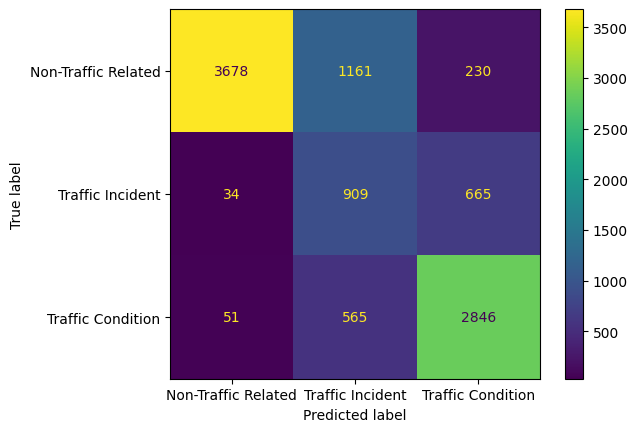

Total Running Time: 684.12 seconds


In [ ]:
# Start the timer
start_time = time.time()
# Set up the device
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU
# Use the "facebook/bart-large-mnli" model for zero-shot classification
model_name = "facebook/bart-large-mnli"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Define the three labels and hypothesis template
labels = ['Non-Traffic Related', 'Traffic Incident', 'Traffic Condition']
hypothesis_template = "This text is {}."

# Apply the classifier directly to the DataFrame using Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

def apply_classifier(batch):
    results = classifier(batch['text'], labels, hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)
df = df_dataset.to_pandas()  # Convert back to pandas DataFrame

# Calculate metrics
y_true = df['Textlabel'].str.lower()
y_pred = df['Predicted_label'].str.lower()

# Accuracy
accuracy = (y_pred == y_true).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification Report
report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
print(report)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
plt.show()

# End the timer and print running time
end_time = time.time()
print(f"Total Running Time: {end_time - start_time:.2f} seconds")

In [ ]:
#5.model_name="facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else -1  # if GPU is available, use it, otherwise use CPU
# Set up the zero-shot classification pipeline with the BERT model and GPU
model_name="facebook/bart-large-mnli"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Convert the DataFrame to a Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

# Define the lables
labels = ['Traffic Incident or Accident Related', 'Not Traffic Incident nor Accident Related']

hypothesis_template = "This text is {}."
#hypothesis_template=hypothesis_template
# Function to apply the classifier to each batch
def apply_classifier(batch):
    results = classifier(batch['Text'], labels,hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

# Apply the function using map in batches
df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)

# Convert the dataset back to a pandas DataFrame
df = df_dataset.to_pandas()

# Now compare the predicted genres with the actual genres to calculate the accuracy
correct_predictions = sum(df['Predicted_label'].str.lower() == df['label'].str.lower())
accuracy = correct_predictions / len(df)
print(f"Accuracy: {accuracy * 100:.2f}%")
#57.39% 42.2

### Model 6. Distill-Bart-mnli-12-1

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/890M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Map:   0%|          | 0/10139 [00:00<?, ? examples/s]

Accuracy: 81.53%
                     precision    recall  f1-score   support

Non-Traffic Related       0.88      0.97      0.93      5069
   Traffic Incident       0.62      0.31      0.41      1608
  Traffic Condition       0.76      0.82      0.79      3462

           accuracy                           0.82     10139
          macro avg       0.75      0.70      0.71     10139
       weighted avg       0.80      0.82      0.80     10139



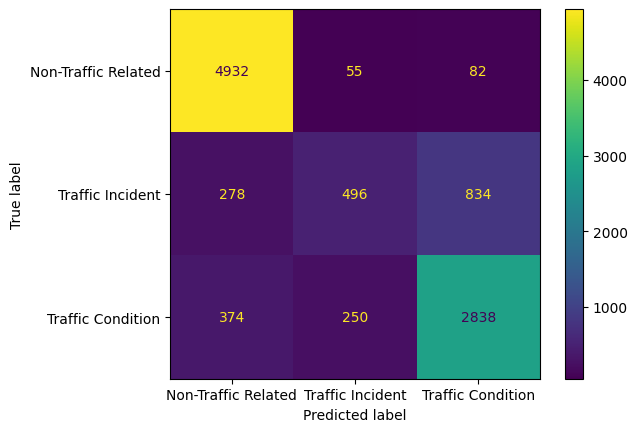

Total Running Time: 347.25 seconds


In [ ]:
# Start the timer
start_time = time.time()
# Set up the device
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU
# Use the "valhalla/distilbart-mnli-12-1" model for zero-shot classification
model_name = "valhalla/distilbart-mnli-12-1"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Define the three labels and hypothesis template
labels = ['Non-Traffic Related', 'Traffic Incident', 'Traffic Condition']
hypothesis_template = "This text is {}."

# Apply the classifier directly to the DataFrame using Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

def apply_classifier(batch):
    results = classifier(batch['text'], labels, hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)
df = df_dataset.to_pandas()  # Convert back to pandas DataFrame

# Calculate metrics
y_true = df['Textlabel'].str.lower()
y_pred = df['Predicted_label'].str.lower()

# Accuracy
accuracy = (y_pred == y_true).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification Report
report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
print(report)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
plt.show()

# End the timer and print running time
end_time = time.time()
print(f"Total Running Time: {end_time - start_time:.2f} seconds")

In [ ]:
#6.model_name ="valhalla/distilbart-mnli-12-1"
device = 0 if torch.cuda.is_available() else -1  # if GPU is available, use it, otherwise use CPU
# Set up the zero-shot classification pipeline with the BERT model and GPU
model_name ="valhalla/distilbart-mnli-12-1"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Convert the DataFrame to a Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

# Define the lables
labels = ['Traffic Incident or Accident Related', 'Not Traffic Incident nor Accident Related']

hypothesis_template = "This text is {}."
#hypothesis_template=hypothesis_template
# Function to apply the classifier to each batch
def apply_classifier(batch):
    results = classifier(batch['Text'], labels,hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

# Apply the function using map in batches
df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)

# Convert the dataset back to a pandas DataFrame
df = df_dataset.to_pandas()

# Now compare the predicted genres with the actual genres to calculate the accuracy
correct_predictions = sum(df['Predicted_label'].str.lower() == df['label'].str.lower())
accuracy = correct_predictions / len(df)
print(f"Accuracy: {accuracy * 100:.2f}%")
#57.39% 42.2

### Model 7. Nli-distil-Roberta-base

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Map:   0%|          | 0/10139 [00:00<?, ? examples/s]

Accuracy: 31.72%
                     precision    recall  f1-score   support

Non-Traffic Related       0.97      0.32      0.48      5069
   Traffic Incident       0.18      0.96      0.31      1608
  Traffic Condition       0.73      0.02      0.03      3462

           accuracy                           0.32     10139
          macro avg       0.63      0.43      0.27     10139
       weighted avg       0.76      0.32      0.30     10139



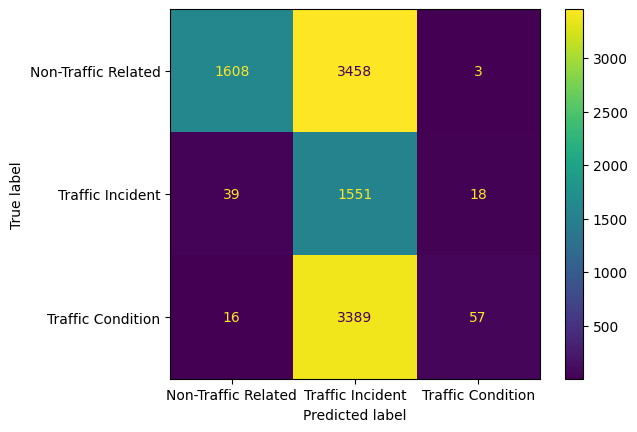

Total Running Time: 185.45 seconds


In [ ]:
# Start the timer
start_time = time.time()
# Set up the device
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU
# Use the "cross-encoder/nli-distilroberta-base" model for zero-shot classification
model_name = "cross-encoder/nli-distilroberta-base"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Define the three labels and hypothesis template
labels = ['Non-Traffic Related', 'Traffic Incident', 'Traffic Condition']
hypothesis_template = "This text is {}."

# Apply the classifier directly to the DataFrame using Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

def apply_classifier(batch):
    results = classifier(batch['text'], labels, hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)
df = df_dataset.to_pandas()  # Convert back to pandas DataFrame

# Calculate metrics
y_true = df['Textlabel'].str.lower()
y_pred = df['Predicted_label'].str.lower()

# Accuracy
accuracy = (y_pred == y_true).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification Report
report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
print(report)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
plt.show()

# End the timer and print running time
end_time = time.time()
print(f"Total Running Time: {end_time - start_time:.2f} seconds")

In [ ]:
#7.model_name="cross-encoder/nli-distilroberta-base"
device = 0 if torch.cuda.is_available() else -1  # if GPU is available, use it, otherwise use CPU
# Set up the zero-shot classification pipeline with the BERT model and GPU
model_name="cross-encoder/nli-distilroberta-base"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)

# Convert the DataFrame to a Hugging Face Dataset
df_dataset = Dataset.from_pandas(df)

# Define the lables
labels = ['Traffic Incident or Accident Related', 'Not Traffic Incident nor Accident Related']

hypothesis_template = "This text is {}."
#hypothesis_template=hypothesis_template
# Function to apply the classifier to each batch
def apply_classifier(batch):
    results = classifier(batch['Text'], labels,hypothesis_template=hypothesis_template)
    return {'Predicted_label': [result["labels"][0] for result in results]}

# Apply the function using map in batches
df_dataset = df_dataset.map(apply_classifier, batched=True, batch_size=8)

# Convert the dataset back to a pandas DataFrame
df = df_dataset.to_pandas()

# Now compare the predicted genres with the actual genres to calculate the accuracy
correct_predictions = sum(df['Predicted_label'].str.lower() == df['label'].str.lower())
accuracy = correct_predictions / len(df)
print(f"Accuracy: {accuracy * 100:.2f}%")
#57.39% 42.2

## Traffic incident report system
collect recent tweets(within 5 minites) with geolocation

In [ ]:
!pip install tweepy


In [ ]:
import tweepy
import os
import csv
# Set your credentials here (securely store them in environment variables if sharing the notebook)
API_KEY = "lH"
API_SECRET = "Im"
ACCESS_TOKEN = "18"
ACCESS_TOKEN_SECRET = "r"
BEARER_TOKEN = "A"

# Authenticate with Twitter API
client = tweepy.Client(bearer_token=BEARER_TOKEN)

def fetch_tweets():
    # Define search parameters
    query = "traffic OR accident OR road OR congestion -is:retweet"  # Keywords, excluding retweets
    max_results = 100  # Max results per request (max 100)
    tweets = []  # To store all fetched tweets
    next_token = None  # For pagination

    while len(tweets) < 900:  # Limit the total number of requests to fit rate limits
        try:
            # Fetch tweets with pagination
            response = client.search_recent_tweets(
                query=query,
                max_results=max_results,
                next_token=next_token,
                tweet_fields=["created_at", "text"],
            )

            # If no data is returned, break the loop
            if not response.data:
                print("No more tweets found.")
                break

            # Append fetched tweets to the list
            for tweet in response.data:
                tweets.append([tweet.id, tweet.text, tweet.created_at])

            # Get the next_token for pagination
            next_token = response.meta.get("next_token")
            if not next_token:  # If there are no more pages, stop fetching
                break

            print(f"Fetched {len(tweets)} tweets so far...")

            # Wait for 1 second to comply with rate limits
            time.sleep(1)

        except tweepy.TooManyRequests:
            print("Rate limit exceeded. Waiting for reset...")
            time.sleep(15 * 60)  # Wait for 15 minutes if rate limit is exceeded

    # Save tweets to a CSV file
    with open("tweets.csv", "w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Tweet ID", "Text", "Created At"])  # Header
        writer.writerows(tweets)  # Write all tweets

    print(f"Tweets saved to tweets.csv. Total tweets fetched: {len(tweets)}")

# Fetch tweets
fetch_tweets()


Rate limit exceeded. Waiting for reset...
Fetched 100 tweets so far...
Rate limit exceeded. Waiting for reset...
Rate limit exceeded. Waiting for reset...
Rate limit exceeded. Waiting for reset...


storing results
https://www.kaggle.com/code/akhilram7/geospatial-and-temporal-distribution-of-tweets

Trail 3: using a dataset about traffic tweets

In [ ]:
import pandas as pd
# Load the dataset with an alternative encoding to handle the issue
file_path = "/content/drive/My Drive/UrbanComputingFall24/GeoTweets.csv"
tweets_data = pd.read_csv(file_path, encoding='latin1')

# Display the first few rows to understand the structure
tweets_data.head()


,TWEET,Geo,latitude,logitude,id,created_at,retweet_count,coordinates
0,94742: Stationary Vehicle on N3 Eastbound afte...,"{'coordinates': [-29.60896477, 30.40999199], '...",-29.608965,30.409992,1.246100e+18,Fri Apr 03 15:44:56 +0000 2020,0,"{'coordinates': [30.40999199, -29.60896477], '..."
1,"Nepean Hwy , Brighton - Traffic Alert, Two lan...","{'coordinates': [-37.89742093, 145.00556709], ...",-37.897421,145.005567,1.246000e+18,Fri Apr 03 09:03:02 +0000 2020,0,"{'coordinates': [145.00556709, -37.89742093], ..."
2,"Racecourse Rd , North Melbourne - Traffic Aler...","{'coordinates': [-37.7891756, 144.94003075], '...",-37.789176,144.940031,1.245970e+18,Fri Apr 03 07:06:02 +0000 2020,0,"{'coordinates': [144.94003075, -37.7891756], '..."
3,"Canterbury Rd , Bayswater North - Traffic Aler...","{'coordinates': [-37.83217074, 145.26937039], ...",-37.832171,145.269370,1.245870e+18,Fri Apr 03 00:06:02 +0000 2020,0,"{'coordinates': [145.26937039, -37.83217074], ..."
4,94730: Stationary Vehicle on N3 Westbound afte...,"{'coordinates': [-29.82234686, 30.8069087], 't...",-29.822347,30.806909,1.245830e+18,Thu Apr 02 21:31:14 +0000 2020,0,"{'coordinates': [30.8069087, -29.82234686], 't..."


In [ ]:
!pip install transformers folium pandas

In [ ]:
import folium
# Create a folium map centered on the average latitude and longitude
map_center = [tweets_data['latitude'].mean(), tweets_data['logitude'].mean()]
tweet_map = folium.Map(location=map_center, zoom_start=10)

# Add each tweet to the map as a circle marker
for _, row in tweets_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['logitude']],  # Latitude and longitude
        radius=5,  # Radius of the circle
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=f"TWEET: {row['TWEET']}\nTime: {row['created_at']}"  # Display tweet and time on hover
    ).add_to(tweet_map)

# Save the map to an HTML file
map_file_path = '/content/drive/My Drive/UrbanComputingFall24//tweet_map.html'
tweet_map.save(map_file_path)

map_file_path


'/content/drive/My Drive/UrbanComputingFall24//tweet_map.html'

In [ ]:
import pandas as pd
import folium
from transformers import pipeline

# Load the dataset
file_path = '/content/drive/My Drive/UrbanComputingFall24/GeoTweets.csv'
tweets_data = pd.read_csv(file_path, encoding='latin1')

# Check GPU availability and set device
device = 0 if torch.cuda.is_available() else -1
# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli",device=device)
# Define classification labels
labels = ["Traffic Incident", "Traffic Condition"]

# Function to classify tweets with keyword adjustment
def classify_tweet_with_keywords(text):
    # Check for specific keywords to force classification as Traffic Incident
    incident_keywords = ["incident", "crash", "accident", "collision", "wreck"]
    if any(keyword in text.lower() for keyword in incident_keywords):
        return "Traffic Incident"
    # Use the DistilBART model for other cases
    result = classifier(text, labels)
    return result["labels"][0]  # Return the highest scoring label

# Apply classification to the dataset
tweets_data['Category'] = tweets_data['TWEET'].apply(classify_tweet_with_keywords)

# Calculate classification percentages
total_tweets = len(tweets_data)
incident_tweets = len(tweets_data[tweets_data['Category'] == "Traffic Incident"])
condition_tweets = len(tweets_data[tweets_data['Category'] == "Traffic Condition"])

incident_percentage = (incident_tweets / total_tweets) * 100
condition_percentage = (condition_tweets / total_tweets) * 100

print(f"Total Tweets: {total_tweets}")
print(f"Traffic Incidents: {incident_tweets} ({incident_percentage:.2f}%)")
print(f"Traffic Conditions: {condition_tweets} ({condition_percentage:.2f}%)")

# Visualize classified tweets on a map
map_center = [tweets_data['latitude'].mean(), tweets_data['logitude'].mean()]
tweet_map = folium.Map(location=map_center, zoom_start=10)

# Add each tweet to the map with color based on category
for _, row in tweets_data.iterrows():
    color = "red" if row['Category'] == "Traffic Incident" else "yellow"
    folium.CircleMarker(
        location=[row['latitude'], row['logitude']],  # Latitude and longitude
        radius=5,  # Radius of the circle
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"TWEET: {row['TWEET']}\nCategory: {row['Category']}\nTime: {row['created_at']}"  # Display tweet and category
    ).add_to(tweet_map)

# Save the map to an HTML file
map_file_path = '/content/drive/My Drive/UrbanComputingFall24//tweet_map_classified2.html'
tweet_map.save(map_file_path)

print("Map created successfully and saved at:", map_file_path)


Total Tweets: 1254
Traffic Incidents: 168 (13.40%)
Traffic Conditions: 1086 (86.60%)
Map created successfully and saved at: /content/drive/My Drive/UrbanComputingFall24//tweet_map_classified2.html
